In [1]:
"""

Ref: https://blog.collegefootballdata.com/talking-tech-building-an-artifical-neural-network-to/

"""
import cfbd
import numpy as np
import pandas as pd
import os
import lightgbm as lgbm
from sklearn.model_selection import train_test_split
import optuna
import pickle
from datetime import datetime

from sklearn.decomposition import TruncatedSVD
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

c:\Users\Kyle\Documents\Projects\staturdays\.venv\Lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
X_train, X_valid, X_test, y_train, y_valid, y_test = (
    pd.read_parquet(path="./X_train.parquet"), 
    pd.read_parquet(path="./X_valid.parquet"), 
    pd.read_parquet(path="./X_test.parquet"), 
    pd.read_parquet(path="./y_train.parquet"), 
    pd.read_parquet(path="./y_valid.parquet"),
    pd.read_parquet(path="./y_test.parquet")
)

In [3]:
exclude = [
    "id",
    "season",
    "year",
    'season_type',
 'start_date',
 'completed',
 'home_ml',
 'away_ml',
 'spread_open',
 'over_under_open',
 'team_home',
 'team_away',
 "home_post_wp",
 "away_post_wp",
 "home_team",
 "away_team",
 "home_points",
 "away_points",
 "srs_rating_home",
 "srs_ranking_home",
 "srs_rating_away",
 "srs_ranking_away",
]

# Training

In [4]:
# Model
lgbm_reg = lgbm.LGBMRegressor(
    # constants
    boosting_type="gbdt",
    learning_rate=0.001,
    n_estimators=10000,
    objective="mae",
    subsample_freq=1, # subsample every time
    random_state=0,
    early_stopping_round=10,
    # tuned
    reg_alpha=3.9740293140705107,
    reg_lambda=1.881540488130314,
    colsample_bytree=1.0,  # percent of features to randomly select for use on each tree
    subsample=0.6,  # percent of data to sample without resampling. only works if bagging_freq is also set
    # bagging_freq=1,  # bag by subsample every kth tree
    max_depth=4,
    num_leaves=873,  # should be less than 2^max_depth. Should be significantly less to avoid overfitting
    min_child_samples=42,
    min_data_per_groups=92,
    # meta
    force_col_wise=True,
)

lgbm_reg.fit(
    X=X_train.drop(columns=exclude), 
    y=y_train,
    eval_set=(X_valid.drop(columns=exclude), y_valid),
    )

[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Total Bins 17456
[LightGBM] [Info] Number of data points in the train set: 4767, number of used features: 82
[LightGBM] [Warning] Unknown parameter: min_data_per_groups
[LightGBM] [Info] Start training from score -6.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
Training until validation scores don't improve for 10 rounds
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive 

LGBMRegressor(early_stopping_round=10, force_col_wise=True, learning_rate=0.001,
              max_depth=4, min_child_samples=42, min_data_per_groups=92,
              n_estimators=10000, num_leaves=873, objective='mae',
              random_state=0, reg_alpha=3.9740293140705107,
              reg_lambda=1.881540488130314, subsample=0.6, subsample_freq=1)

# Eval

Feature Importance

In [5]:
feat_imp = pd.DataFrame({"feat": lgbm_reg.feature_name_, "imp": lgbm_reg.feature_importances_}).sort_values(by="imp", ascending=False)

<Axes: ylabel='feat'>

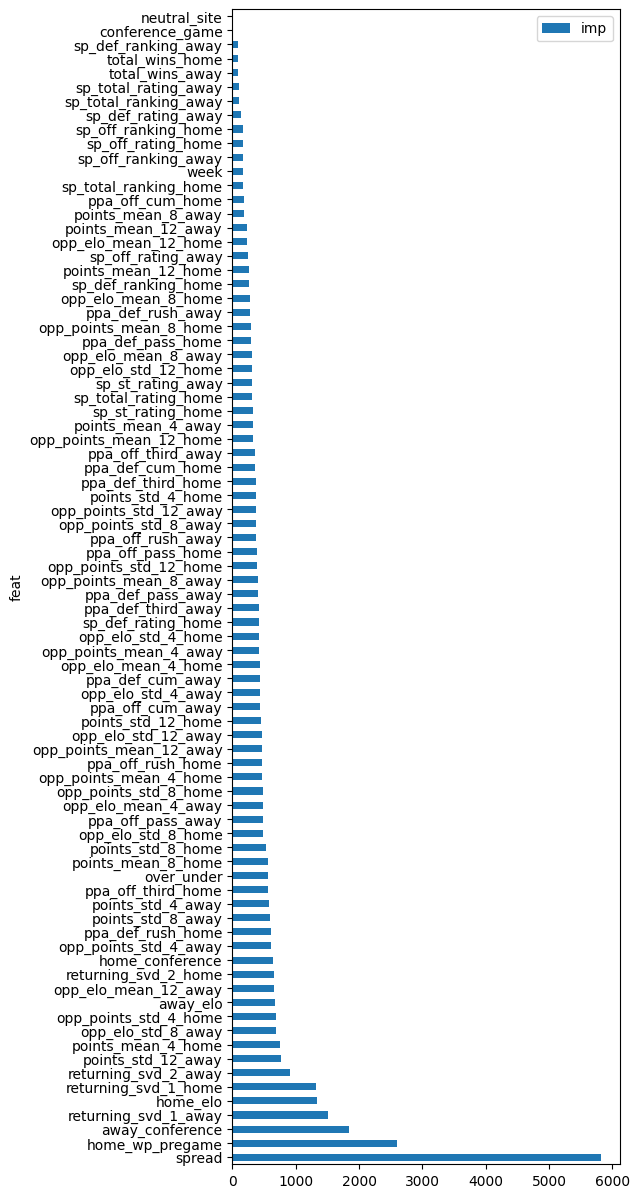

In [6]:
feat_imp.plot(x="feat", y="imp", kind="barh", figsize=(5,15))

In [7]:
y_preds = lgbm_reg.predict(X_test.drop(columns=exclude))

[LightGBM] [Warning] Unknown parameter: min_data_per_groups


In [8]:
y_preds = pd.Series(y_preds, name="preds")

In [9]:
eval_df = pd.DataFrame({"preds": y_preds, "actual": y_test["margin"].reset_index(drop=True)})
eval_df["mae"] = abs(eval_df["preds"] - eval_df["actual"])
eval_df["mae"].describe()

count    799.000000
mean      12.475881
std        9.303425
min        0.077288
25%        5.090844
50%       10.468282
75%       17.820452
max       49.195148
Name: mae, dtype: float64

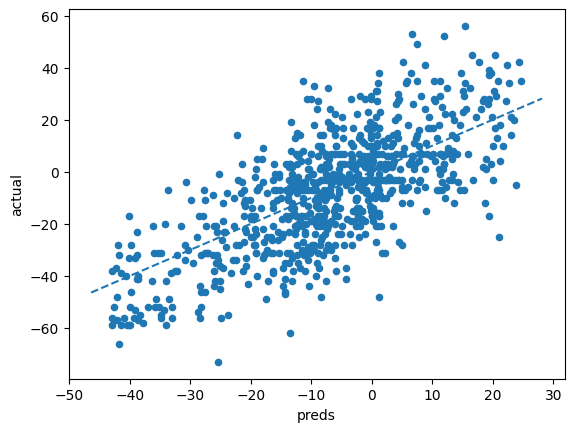

In [10]:
import matplotlib.pyplot as plt 
import numpy as np    

def abline(slope, intercept):
    """Plot a line from slope and intercept"""
    axes = plt.gca()
    x_vals = np.array(axes.get_xlim())
    y_vals = intercept + slope * x_vals
    plt.plot(x_vals, y_vals, '--')

eval_df.plot(x="preds", y="actual", kind="scatter")
abline(1, 0)

<Axes: xlabel='bucket'>

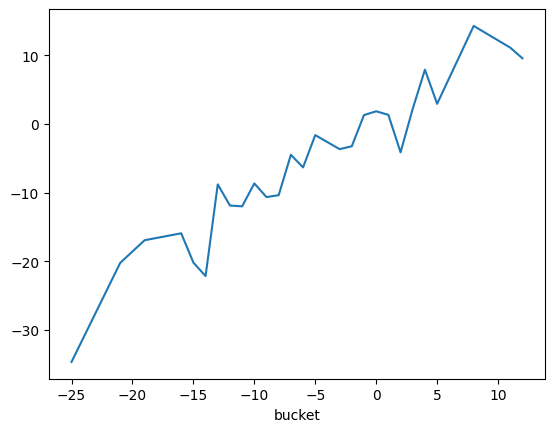

In [11]:
eval_df.assign(bucket=round(eval_df["preds"], 0)).groupby("bucket")["actual"].agg(["mean", "count"]).query("count > 10")["mean"].plot()

Compare to straight up, ATS.

In [12]:
eval_df["spread"] = X_test.spread.reset_index(drop=True)
eval_df["spread_mae"] = abs(eval_df["spread"] - eval_df["actual"])
eval_df.filter(like="mae").describe()

,mae,spread_mae
count,799.000000,784.000000
mean,12.475881,12.172194
std,9.303425,9.257544
min,0.077288,0.000000
25%,5.090844,5.000000
50%,10.468282,10.500000
75%,17.820452,17.125000
max,49.195148,59.000000


Straight Up

Model:

In [13]:
straight_up = (np.sign(eval_df["preds"]) == np.sign(eval_df["actual"])).sum() / len(eval_df)

Spread:

In [14]:
straight_up_vs_spread = straight_up - ((np.sign(eval_df["spread"]) == np.sign(eval_df["actual"])).sum() / len(eval_df))

ATS

In [15]:
ats = (abs(eval_df["preds"] - eval_df["actual"]) < abs(eval_df["spread"] - eval_df["actual"])).sum() / len(eval_df["spread"].dropna())

Log Model Results

In [16]:
date = format(datetime.today(), "%Y-%m-%d-%H-%M")
model_name = f"model-{date}"

In [17]:
eval_dict = {
    "best_mae": lgbm_reg.best_score_["valid_0"]["l1"],
    "ats": ats,
    "straight_up": straight_up,
    "straight_up_vs_spread": straight_up_vs_spread,
    "top_feats": feat_imp.head(10),
}

eval_dict

{'best_mae': 12.942238477730847,
 'ats': 0.49489795918367346,
 'straight_up': 0.7496871088861077,
 'straight_up_vs_spread': 0.006257822277847325,
 'top_feats':                     feat   imp
 8                 spread  5826
 43       home_wp_pregame  2595
 5        away_conference  1841
 11  returning_svd_1_away  1517
 4               home_elo  1328
 9   returning_svd_1_home  1314
 12  returning_svd_2_away   909
 77    points_std_12_away   763
 45    points_mean_4_home   754
 75    opp_elo_std_8_away   690}

In [18]:
with open(f"./eval-{model_name}.txt", "w") as f:
    f.write(str(eval_dict))

# Hyperparam Tuning

In [64]:
iter = []

from sklearn.metrics import mean_absolute_error
def objective(trial,data=None,target=None):
    
    # train_x, test_x, train_y, test_y = train_test_split(data, target, test_size=0.2,random_state=42)
    param = {
        'metric': 'mae', 
        'random_state': 0,
        'n_estimators': 10000,
        "learning_rate": 0.001,
        "subsample_freq": 1,
        "early_stopping_rounds": 10,
        "force_col_wise": True,
        'reg_alpha': trial.suggest_float('reg_alpha', 1e-3, 10.0, log=True),
        'reg_lambda': trial.suggest_float('reg_lambda', 1e-3, 10.0, log=True),
        'colsample_bytree': trial.suggest_categorical('colsample_bytree', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'subsample': trial.suggest_categorical('subsample', [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]),
        'bagging_freq': trial.suggest_categorical('bagging_freq', [1,2,3,5,10]),
        'max_depth': trial.suggest_int('max_depth', 1,6),
        'num_leaves' : trial.suggest_int('num_leaves', 2, 1000),
        'min_child_samples': trial.suggest_int('min_child_samples', 1, 50),
        'min_data_per_group' : trial.suggest_int('min_data_per_group', 1, 100),
        'cat_smooth' : trial.suggest_float('cat_smooth', 1e-3, 25),
    }
    model = lgbm.LGBMRegressor(**param, verbosity=-1)
    
    model.fit(X_train.drop(columns=exclude),y_train,eval_set=[(X_valid.drop(columns=exclude),y_valid)])

    iter.append(model.best_iteration_)
    
    preds = model.predict(X_test.drop(columns=exclude))
    
    mae = mean_absolute_error(y_true=y_test, y_pred=preds)
    
    return mae

In [65]:
study = optuna.create_study(direction='minimize')
study.optimize(objective, n_trials=25)
print('Number of finished trials:', len(study.trials))
print('Best trial:', study.best_trial.params)

[I 2023-09-23 11:13:44,731] A new study created in memory with name: no-name-85cc8a4b-1083-4bc0-b31e-2a79014957fd
[I 2023-09-23 11:13:53,660] Trial 0 finished with value: 12.577230199108671 and parameters: {'reg_alpha': 0.7851175974569335, 'reg_lambda': 0.002831950929229856, 'colsample_bytree': 0.3, 'subsample': 0.9, 'bagging_freq': 5, 'max_depth': 6, 'num_leaves': 911, 'min_child_samples': 39, 'min_data_per_group': 59, 'cat_smooth': 15.8537460318161}. Best is trial 0 with value: 12.577230199108671.
[I 2023-09-23 11:14:08,278] Trial 1 finished with value: 12.505464796040648 and parameters: {'reg_alpha': 0.0014753568475495721, 'reg_lambda': 2.468993270369029, 'colsample_bytree': 1.0, 'subsample': 0.9, 'bagging_freq': 5, 'max_depth': 6, 'num_leaves': 730, 'min_child_samples': 46, 'min_data_per_group': 27, 'cat_smooth': 8.949478832330422}. Best is trial 1 with value: 12.505464796040648.
[I 2023-09-23 11:14:17,841] Trial 2 finished with value: 12.422179901210045 and parameters: {'reg_alpha

Number of finished trials: 25
Best trial: {'reg_alpha': 0.010201466156039878, 'reg_lambda': 0.0025893086364545672, 'colsample_bytree': 0.9, 'subsample': 0.4, 'bagging_freq': 1, 'max_depth': 4, 'num_leaves': 643, 'min_child_samples': 7, 'min_data_per_group': 12, 'cat_smooth': 7.1797479687496395}


In [66]:
study.best_value

12.359729527918601

In [67]:
best_iter = iter[study.best_trial.number]
best_iter

3250

In [68]:
study.best_params

{'reg_alpha': 0.010201466156039878,
 'reg_lambda': 0.0025893086364545672,
 'colsample_bytree': 0.9,
 'subsample': 0.4,
 'bagging_freq': 1,
 'max_depth': 4,
 'num_leaves': 643,
 'min_child_samples': 7,
 'min_data_per_group': 12,
 'cat_smooth': 7.1797479687496395}

# Retrain Model on Full Data

In [69]:
# Join train, valid, and test
X = pd.concat([X_train, X_valid, X_test], axis=0)
y = pd.concat([y_train, y_valid, y_test], axis=0)

In [70]:
# Train
# Model
lgbm_reg = lgbm.LGBMRegressor(
    # constants
    boosting_type="gbdt",
    learning_rate=0.001,
    n_estimators=best_iter,
    objective="mae",
    subsample_freq=1, # subsample every time
    random_state=0,
    # tuned
    **study.best_params,
    # meta
    force_col_wise=True,
)

lgbm_reg.fit(
    X=X.drop(columns=exclude), 
    y=y,
    )

[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=1 will be ignored. Current value: bagging_freq=1
[LightGBM] [Warning] bagging_freq is set=1, subsample_freq=1 will be ignored. Current value: bagging_freq=1
[LightGBM] [Info] Total Bins 17522
[LightGBM] [Info] Number of data points in the train set: 6758, number of used features: 82
[LightGBM] [Info] Start training from score -6.000000
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[LightGBM] [Warning] No further splits with positive gain, best gain: -inf
[Li

LGBMRegressor(bagging_freq=1, cat_smooth=7.1797479687496395,
              colsample_bytree=0.9, force_col_wise=True, learning_rate=0.001,
              max_depth=4, min_child_samples=7, min_data_per_group=12,
              n_estimators=3250, num_leaves=643, objective='mae',
              random_state=0, reg_alpha=0.010201466156039878,
              reg_lambda=0.0025893086364545672, subsample=0.4,
              subsample_freq=1)

# Save Model

In [71]:
with open(f"./{model_name}.pickle", "wb") as f:
    pickle.dump(lgbm_reg, f)